# Introduction to Machine Learning
## Project Phase 2

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [56]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sympy import mod_inverse
import torch.nn as nn
import torch.optim as optim

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

# getting the train data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

In [5]:
# getting the test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

X_test_torch = testset.data
Y_test_torch = testset.targets

X_test = X_test_torch.numpy()
Y_test = Y_test_torch.numpy()

To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [6]:
threshold = 128

X_test = (X_test > threshold).astype(np.uint32)
X_test_binary = X_test.reshape(-1, 28 * 28)

X_train = (X_train > threshold).astype(np.uint32)
X_train_binary = X_train.reshape(-1, 28 * 28)

The plot to show the samples:

In [7]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

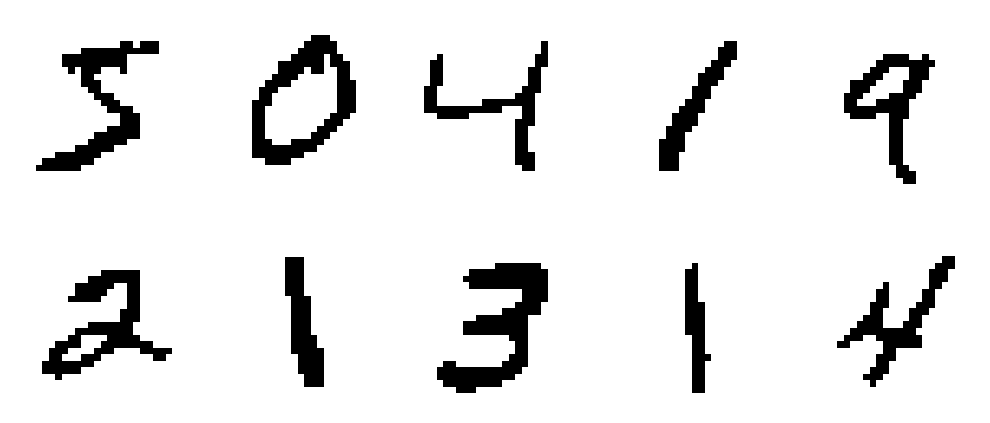

In [8]:
show_samples(X_train_binary[:10])

# Simple Boltzman machine:

The Boltzmann machine is like the one we used in the first phase of the project and follow the same patterns to update the parameters.

In [16]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        v_neg = v.copy()

        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
            sample = np.random.binomial(1, 0.5, self.n_hidden)
            sample = self.gibbs_sampling(sample, k)
            samples.append(sample)
        return np.array(samples)

Based on the simulations in phase 1 we define the number of hidden layers and k as follow:

In [17]:
n_visible = X_train_binary.shape[1]
n_hidden = 32
k_values = [1, 5, 10]

Now we train the model on the MNIST dataset:

In [18]:
# training
rbms = {}
for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00198
Epoch 2/10, Loss: 0.00160
Epoch 3/10, Loss: 0.00152
Epoch 4/10, Loss: 0.00148
Epoch 5/10, Loss: 0.00146
Epoch 6/10, Loss: 0.00145
Epoch 7/10, Loss: 0.00144
Epoch 8/10, Loss: 0.00143
Epoch 9/10, Loss: 0.00143
Epoch 10/10, Loss: 0.00142
Training RBM with k=5
Epoch 1/10, Loss: 0.00221
Epoch 2/10, Loss: 0.00174
Epoch 3/10, Loss: 0.00163
Epoch 4/10, Loss: 0.00158
Epoch 5/10, Loss: 0.00154
Epoch 6/10, Loss: 0.00152
Epoch 7/10, Loss: 0.00151
Epoch 8/10, Loss: 0.00150
Epoch 9/10, Loss: 0.00149
Epoch 10/10, Loss: 0.00148
Training RBM with k=10
Epoch 1/10, Loss: 0.00229
Epoch 2/10, Loss: 0.00180
Epoch 3/10, Loss: 0.00170
Epoch 4/10, Loss: 0.00164
Epoch 5/10, Loss: 0.00160
Epoch 6/10, Loss: 0.00157
Epoch 7/10, Loss: 0.00156
Epoch 8/10, Loss: 0.00154
Epoch 9/10, Loss: 0.00153
Epoch 10/10, Loss: 0.00153


As you can see, the model is converging and the loss is getting lower to a fixed point.

As we increase k, the final loss of the model on the training data is not getting better but based on the results of the first phase, we know that the model with a higher k performs better on the test datas and gives better resuls.

To test these models, we use the test dataset of the MNIST:

In [69]:
def evaluate_rbm(rbm, data):
    loss = 0
    for i in range(0, len(data), 64):
        batch = data[i:i+64]
        v_neg = rbm.contrastive_divergence(batch, k=1)
        loss += np.mean((batch - v_neg) ** 2)
    avg_loss = loss / (len(data) / 64)
    return avg_loss

simple_losses = {}
for k in k_values:
    loss = evaluate_rbm(rbms[k], X_test_binary)
    simple_losses[k] = loss
    print(f"Simple RBM with k={k} Test Loss: {loss:.5f}")

Simple RBM with k=1 Test Loss: 0.08991
Simple RBM with k=5 Test Loss: 0.08803
Simple RBM with k=10 Test Loss: 0.08726


The test loss is getting better by increasing k. This confirms the results discussed in the phase 1.

# The Secure Boltzman Machine:

As we learned from the project file, the Secure Boltzmann Machine works with two parties. Each party have a specific number of parameters and each have they're own weights and biases.

To update the parameters, we use ElGamal encryption so that both models can calculate loss with needed values (e.g. $v_1h_2$). To implement this, we approach like the model below:

In [21]:
class SecureRBM:
    def __init__(self, n_visible, n_hidden, mA, learning_rate=0.1, p=467):
        """
        Initialize SecureRBM for two parties A and B.

        Parameters:
        - n_visible: total number of visible neurons (e.g., 784 for MNIST).
        - n_hidden: number of hidden neurons.
        - mA: number of visible features belonging to Party A.
          (Then mB = n_visible - mA belong to Party B.)
        - learning_rate: learning rate for weight updates.
        - p: a prime number used for the ElGamal-based secure operations.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.mA = mA
        self.mB = n_visible - mA
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)
        self.p = p

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def generate_keys(self):
        """
        Generate ElGamal public and private keys.
        """
        g = random.randint(2, self.p - 2)
        x = random.randint(1, self.p - 2)
        y = pow(g, x, self.p)
        return (self.p, g, y), x

    def encrypt(self, public_key, message):
        """
        Encrypt a message (an integer) using the public key.
        """
        p, g, y = public_key
        k = random.randint(1, p - 2)
        c1 = pow(g, k, p)
        c2 = (int(message) * pow(y, k, p)) % p
        return (c1, c2)

    def decrypt_partial(self, private_key, public_key, ciphertext):
        """
        Partially decrypt a ciphertext using the private key.
        """
        p, g, y = public_key
        c1, c2 = ciphertext
        s = pow(c1, private_key, p)
        return (c2, s)

    def decrypt_final(self, partially_decrypted, p):
        """
        Final decryption using the modular inverse.
        """
        c2, s = partially_decrypted
        s_inv = mod_inverse(s, p)
        message = (c2 * s_inv) % p
        return message

    def sample_hidden_secure(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the hidden layer using contributions from both parties.

        Parameters:
        - v: input visible data (batch, n_visible)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_hidden)

        Returns:
        - Binary samples for hidden layer (batch, n_hidden)
        """
        # Split visible input: Party A's part and Party B's part.
        vA = v[:, :self.mA]
        vB = v[:, self.mA:]

        # Split the weight matrix W accordingly.
        WA = self.W[:self.mA, :]
        WB = self.W[self.mA:, :]

        # Each party computes its partial activation. we assume all the bias is on party A's side
        act_A = np.dot(vA, WA) + self.h_bias
        act_B = np.dot(vB, WB)

        # Joint secure activation: each party encrypts its share, then they are combined.
        # Here we simulate secure computation by simply summing the parts.
        joint_act = act_A + act_B
        # Apply random mask removal.
        final_act = joint_act - random_r
        # Compute secure sigmoid and sample hidden units.
        h_prob = self.sigmoid(final_act)
        return self.sample(h_prob)

    def sample_visible_secure(self, h, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the visible layer.

        Parameters:
        - h: hidden layer activations (batch, n_hidden)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_visible)

        Returns:
        - Binary reconstruction of the visible layer (batch, n_visible)
        """
        # For the visible layer, assume Party A owns the first mA visible units and Party B the rest.
        WA_T = self.W[:self.mA, :].T
        WB_T = self.W[self.mA:, :].T
        bA = self.v_bias[:self.mA]
        bB = self.v_bias[self.mA:]

        act_A = np.dot(h, WA_T) + bA
        act_B = np.dot(h, WB_T) + bB

        # Combine secure activations
        joint_act = np.concatenate([act_A, act_B], axis=1)
        final_act = joint_act - random_r
        v_prob = self.sigmoid(final_act)
        return self.sample(v_prob)

    def reconstruct(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely reconstruct the visible input.
        """
        h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
        v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
        return v_recon

    def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Perform one step of secure Contrastive Divergence.
        """
        # For simplicity, we perform ordinary Gibbs sampling.
        # In a real implementation, secure operations would be applied at each step.
        v_neg = v.copy()
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob)
        # Compute gradients using standard (non-secure) operations.
        h_prob_data = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
        positive_grad = np.dot(v.T, h_prob_data)
        negative_grad = np.dot(v_neg.T, h_prob_neg)
        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_data - h_prob_neg, axis=0)
        return v_neg

    def train_secure(self, data, epochs=10, k=1, batch_size=64,
                     public_key_a=None, private_key_a=None,
                     public_key_b=None, private_key_b=None):
        """
        Train the SecureRBM model using secure Contrastive Divergence.
        """
        num_batches = len(data) // batch_size
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                # Generate a random mask for both hidden and visible layers.
                # For visible: shape (batch, n_visible)
                mask_scale = 0.1  # or another small constant
                random_r = np.random.randint(1, int(self.p * mask_scale), size=(batch.shape[0], self.n_visible))
                # Reconstruct the batch using secure operations.
                v_recon = self.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
                loss = np.mean((batch - v_recon) ** 2)
                epoch_loss += loss
                # Update parameters using secure Contrastive Divergence simulation.
                self.contrastive_divergence_secure(batch, k, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs}, Secure Loss: {avg_loss:.5f}")

    def generate_samples(self, n_samples=10, k=1,
                         public_key_a=None, private_key_a=None,
                         public_key_b=None, private_key_b=None):
        """
        Generate new samples from the trained SecureRBM model.
        """
        samples = []
        for _ in range(n_samples):
            # Start with a random visible vector.
            v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
            mask_scale = 0.1
            random_r = np.random.randint(1, int(self.p * mask_scale), size=(1, self.n_visible))
            for _ in range(k):
                h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
                v = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            samples.append(v.flatten())
        return np.array(samples)


**DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD**

Training the Secure Model:

In [22]:
# defining the parameters
n_visible = 784
n_hidden = 32
mA = 392

secure_rbm = SecureRBM(n_visible, n_hidden, mA, learning_rate=0.01, p=467)
public_key_a, private_key_a = secure_rbm.generate_keys()
public_key_b, private_key_b = secure_rbm.generate_keys()

# train
secure_rbm.train_secure(X_train_binary, epochs=15, k=5,
                        public_key_a=public_key_a, private_key_a=private_key_a,
                        public_key_b=public_key_b, private_key_b=private_key_b)

Epoch 1/15, Secure Loss: 0.13478
Epoch 2/15, Secure Loss: 0.13329
Epoch 3/15, Secure Loss: 0.13287
Epoch 4/15, Secure Loss: 0.13260
Epoch 5/15, Secure Loss: 0.13239
Epoch 6/15, Secure Loss: 0.13224
Epoch 7/15, Secure Loss: 0.13212
Epoch 8/15, Secure Loss: 0.13203
Epoch 9/15, Secure Loss: 0.13192
Epoch 10/15, Secure Loss: 0.13183
Epoch 11/15, Secure Loss: 0.13177
Epoch 12/15, Secure Loss: 0.13169
Epoch 13/15, Secure Loss: 0.13163
Epoch 14/15, Secure Loss: 0.13158
Epoch 15/15, Secure Loss: 0.13153


Evaluating the secure model:

In [15]:
# ارزیابی ماشین بولتزمن امن
def evaluate_secure_rbm(secure_rbm, data, public_key_a, private_key_a, public_key_b, private_key_b, batch_size=64):
    loss = 0.0
    num_batches = len(data) // batch_size
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        # ایجاد یک مقدار تصادفی r برای هر دسته
        random_r = np.random.randint(1, secure_rbm.p, size=(batch.shape[0], 1))

        # بازسازی داده‌ها با استفاده از متدهای امن
        v_recon = secure_rbm.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)

        # محاسبه خطا بین داده‌های اصلی و بازسازی شده
        loss += np.mean((batch - v_recon) ** 2)

    avg_loss = loss / num_batches
    return avg_loss

# ارزیابی ماشین بولتزمن امن
secure_loss = evaluate_secure_rbm(
    secure_rbm,
    X_test_binary,
    public_key_a,
    private_key_a,
    public_key_b,
    private_key_b,
    batch_size=64
)
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

Secure RBM Test Loss: 0.13333


Comparison:

In [20]:
print("Comparing the Simple RBM with ")
print(f"Simple RBM with k=1 Test Loss: {simple_losses[1]:.5f}")
print(f"Simple RBM with k=5 Test Loss: {simple_losses[5]:.5f}")
print(f"Simple RBM with k=10 Test Loss: {simple_losses[10]:.5f}")
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

مقایسه عملکرد ماشین بولتزمن ساده و امن:
Simple RBM with k=1 Test Loss: 0.09028
Simple RBM with k=5 Test Loss: 0.08821
Simple RBM with k=10 Test Loss: 0.08768
Secure RBM Test Loss: 0.13333


# Generative RBM

Preparing the data with labels:

In [50]:
# ---------------------------
# Data Preparation
# ---------------------------
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# One-hot encode the labels (10 classes)
Y_train_oh = one_hot(Y_train, num_classes=10)
Y_test_oh  = one_hot(Y_test, num_classes=10)

# For training the joint model, we concatenate x and y.
# The total visible vector length = 784 (image) + 10 (label) = 794.
V_train = np.concatenate([X_train.reshape(X_train.shape[0], -1), Y_train_oh], axis=1)

The model:

In [51]:
class GenerativeRBM:
    def __init__(self, n_visible, n_hidden, n_labels, learning_rate=0.01):
        """
        n_visible: تعداد ویژگی‌های x (مثلاً 784)
        n_labels: تعداد ابعاد y (مثلاً 10)
        n_hidden: تعداد واحدهای مخفی
        تعداد کل واحدهای قابل مشاهده = n_visible + n_labels (مثلاً 794)
        """
        self.n_visible = n_visible
        self.n_labels = n_labels
        self.nv_total = n_visible + n_labels
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # مقداردهی اولیه به وزن‌ها و بایاس‌ها
        self.W = np.random.normal(0, 0.1, (self.nv_total, n_hidden))
        self.b = np.zeros(self.nv_total)  # بایاس برای x و y
        self.c = np.zeros(n_hidden)       # بایاس لایه پنهان

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.rand(*prob.shape) < prob).astype(np.float32)

    def contrastive_divergence(self, v, k=1):
        # مرحله مثبت: محاسبه احتمالات لایه پنهان
        h_prob = self.sigmoid(np.dot(v, self.W) + self.c)
        h_sample = self.sample(h_prob)

        # مرحله منفی: اجرای k مرحله Gibbs Sampling
        v_neg = v.copy()
        for _ in range(k):
            h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.c)
            h_sample_neg = self.sample(h_prob_neg)
            v_prob_neg = self.sigmoid(np.dot(h_sample_neg, self.W.T) + self.b)
            v_neg = self.sample(v_prob_neg)
        return v_neg, h_prob

    def update(self, v, v_neg, h_prob, h_prob_neg):
        batch_size = v.shape[0]
        positive_grad = np.dot(v.T, h_prob)
        negative_grad = np.dot(v_neg.T, h_prob_neg)
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.b += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.c += self.learning_rate * np.mean(h_prob - h_prob_neg, axis=0)

    def train(self, data, epochs=20, k=1, batch_size=64):
        n_samples = data.shape[0]
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_error = 0
            for i in range(0, n_samples, batch_size):
                batch = data[i:i+batch_size]
                v_neg, h_prob = self.contrastive_divergence(batch, k)
                h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.c)
                self.update(batch, v_neg, h_prob, h_prob_neg)
                epoch_error += np.mean((batch - v_neg)**2)
            avg_err = epoch_error / (n_samples / batch_size)
            print(f"Epoch {epoch+1}/{epochs}, Reconstruction Error: {avg_err:.5f}")

    def free_energy(self, v):
        vbias_term = np.dot(v, self.b)
        wx_b = np.dot(v, self.W) + self.c
        hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis=1)
        return -vbias_term - hidden_term

    def classify(self, x):
        """
        برای هر ورودی x (شکل: (n_samples, n_visible))، با تولید
        بردارهای هم‌افزایی با برچسب‌های ممکن (One-hot) و محاسبه تابع انرژی آزاد،
        برچسبی که انرژی آن کمینه است انتخاب می‌شود.
        """
        n_samples = x.shape[0]
        predictions = np.zeros(n_samples, dtype=np.int32)
        for i in range(n_samples):
            x_i = x[i].reshape(1, -1)
            energies = []
            for label in range(self.n_labels):
                y_candidate = np.zeros((1, self.n_labels))
                y_candidate[0, label] = 1
                v_candidate = np.concatenate([x_i, y_candidate], axis=1)
                energies.append(self.free_energy(v_candidate)[0])
            predictions[i] = np.argmin(energies)
        return predictions

Training the model:

In [53]:
# ---------------------------
# آموزش و ارزیابی مدل Generative RBM
# ---------------------------
n_visible = 784
n_labels = 10
n_hidden = 256
learning_rate = 0.1
epochs = 10
k = 1
batch_size = 64

rbm_joint = GenerativeRBM(n_visible, n_hidden, n_labels, learning_rate)

print("Training Generative RBM on (x,y)...")
rbm_joint.train(V_train, epochs=epochs, k=k, batch_size=batch_size)

Training Generative RBM on (x,y)...
Epoch 1/10, Reconstruction Error: 0.07785
Epoch 2/10, Reconstruction Error: 0.05614
Epoch 3/10, Reconstruction Error: 0.04983
Epoch 4/10, Reconstruction Error: 0.04602
Epoch 5/10, Reconstruction Error: 0.04339
Epoch 6/10, Reconstruction Error: 0.04139
Epoch 7/10, Reconstruction Error: 0.03983
Epoch 8/10, Reconstruction Error: 0.03864
Epoch 9/10, Reconstruction Error: 0.03760
Epoch 10/10, Reconstruction Error: 0.03674


Testing the model:

Generative RBM Classification Accuracy: 93.34%


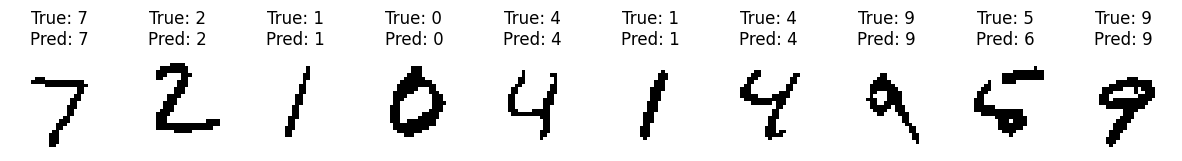

In [54]:
def show_classification_results(x, true_labels, pred_labels, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(x[i].reshape(28,28), cmap='binary')
        ax.set_title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        ax.axis('off')
    plt.show()

predictions_joint = rbm_joint.classify(X_test)
accuracy_joint = np.mean(predictions_joint == Y_test)
print(f"Generative RBM Classification Accuracy: {accuracy_joint*100:.2f}%")

show_classification_results(X_test, Y_test, predictions_joint, n=10)

# Full DRBM model

Preparing the data:

In [57]:
# ---------------------------
# بارگذاری و پیش‌پردازش داده‌ها
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

The model:

In [66]:
class DiscriminativeRBMModel(nn.Module):
    def __init__(self, input_dim=784, num_classes=10, hidden_dim=256):
        super(DiscriminativeRBMModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        # پارامترهای مربوط به بخش تصویر
        self.b = nn.Parameter(torch.zeros(input_dim))
        # پارامترهای مربوط به برچسب
        self.d = nn.Parameter(torch.zeros(num_classes))
        # وزن‌های مربوط به اتصال تصویر به لایه پنهان
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        # وزن‌های مربوط به اتصال برچسب به لایه پنهان
        self.U = nn.Parameter(torch.randn(num_classes, hidden_dim) * 0.1)
        # بایاس لایه پنهان
        self.c = nn.Parameter(torch.zeros(hidden_dim))

    def free_energy(self, x, y):
        vbias_term = torch.matmul(x, self.b) + torch.matmul(y, self.d)
        hidden_linear = torch.matmul(x, self.W) + torch.matmul(y, self.U) + self.c
        # Clamp کردن ورودی به exp برای جلوگیری از overflow
        hidden_linear = torch.clamp(hidden_linear, max=50)
        hidden_term = torch.sum(torch.log(1 + torch.exp(hidden_linear)), dim=1)
        return -vbias_term - hidden_term


    def forward(self, x):
        """
        برای هر نمونه ورودی x (به شکل (batch, 784))، با استفاده از تابع free energy،
        برای هر برچسب ممکن (به صورت One-hot) مقادیر -F(x,y) (که معادل logits هستند) محاسبه می‌شود.
        خروجی logits به شکل (batch, num_classes) خواهد بود.
        """
        batch_size = x.size(0)
        logits = []
        for label in range(self.num_classes):
            y_candidate = torch.zeros(batch_size, self.num_classes, device=x.device)
            y_candidate[:, label] = 1.0
            F = self.free_energy(x, y_candidate)   # (batch,)
            logits.append((-F).unsqueeze(1))
        logits = torch.cat(logits, dim=1)  # (batch, num_classes)
        return logits

Training the model:

In [67]:
# ---------------------------
# آموزش مدل تمایزگر
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiscriminativeRBMModel(input_dim=784, num_classes=10, hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        # بایناریزه کردن تصاویر (اگر لازم باشد)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        logits = model(images)  # (batch, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(trainset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.5f}")

Epoch 1/10, Loss: 0.23599
Epoch 2/10, Loss: 0.10353
Epoch 3/10, Loss: 0.07536
Epoch 4/10, Loss: 0.05815
Epoch 5/10, Loss: 0.05386
Epoch 6/10, Loss: 0.04407
Epoch 7/10, Loss: 0.04030
Epoch 8/10, Loss: 0.03591
Epoch 9/10, Loss: 0.03353
Epoch 10/10, Loss: 0.03283


Testing the model:

In [68]:
# ---------------------------
# ارزیابی مدل تمایزگر
# ---------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)
        logits = model(images)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Discriminative Model Accuracy: {accuracy*100:.2f}%")

Discriminative Model Accuracy: 96.55%
